In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb

In [2]:
Data = pd.read_csv("C:\\Users\\Athena\\Desktop\\Projects\\Research\\SolarStudy\\GridInfo.csv")

In [3]:
Data.head()

,Unnamed: 0,Location,"(1,1) Height","(1,2) Height","(1,3) Height","(2,1) Height","(2,2) Height","(2,3) Height","(3,1) Height","(3,2) Height",...,Street_maximum,Street_minimum,Street_median,Street_25,Street_75,AveragePlots,TotalAverage,Classes,BinaryClasses,TenClasses
0,0,0,69.0,63.0,57.0,51.0,44.0,38.0,32.0,26.0,...,1329,435,855,747,1027,882,887,Medium,High,5
1,1,0,69.0,63.0,57.0,51.0,44.0,38.0,32.0,26.0,...,1323,339,864,753,1017,819,857,Low,Low,0
2,2,0,69.0,63.0,57.0,51.0,44.0,38.0,32.0,26.0,...,1329,328,842,719,1011,858,866,Medium,Low,4
3,3,0,69.0,63.0,57.0,51.0,44.0,38.0,32.0,26.0,...,1329,354,863,739,1044,817,855,Low,Low,0
4,4,0,69.0,63.0,57.0,51.0,44.0,38.0,32.0,26.0,...,1323,410,853,738,1018,848,867,Medium,Low,3


In [4]:
##Preprocess data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

#Split into features and label
X = Data.iloc[:,:70]
y = Data.Classes

##Scale data and label categorical features
scaler = StandardScaler()
labeler = LabelEncoder()
X_temp = scaler.fit_transform(X.drop("Location", axis=1))
X_scaled = np.concatenate((X.Location.values.reshape(-1,1), X_temp), axis=1)
y = labeler.fit_transform(y)

In [5]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=2, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig('C:\\Users\\Athena\\Desktop\\Projects\\Research\\SolarStudy\\Figures\\estimator.png')
    return plt

In [9]:
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier
from skopt.space import Categorical, Real, Integer

In [27]:
##Sklearn and LightGBM - Round 1 of Random search
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

##LightGBM datasets, if needed
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=[0], free_raw_data=False)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature=[0], free_raw_data=False)

##Setting up the classifier
gbm_R1 = lgb.LGBMClassifier(n_estimators=100, n_jobs=3,  tree_learner='feature_parallel',
                            save_binary=True, num_class=3)

opt = BayesSearchCV(
        LGBMClassifier(),
        {
            'boosting_type': ['gbdt', 'dart'],
            'objective': Categorical(['multiclass']),
            'metric': ['multi_error', 'multi_logloss'],
            'max_depth': (3, 6),
            'num_leaves': (10, 60
                           
            'min_data_in_leaf': (10, 40),
            'learning_rate': (0.001, 0.25),
            'colsample_bytree': (0.25,0.9),
            'subsample': (0.25, 0.9),
            'subsample_freq': (1, 10),
            'drop_rate': (0.2, 0.9),
            'max_bin': (150, 500),
            'verbose': Categorical([1])
        },
    n_iter = 500, cv=3,

)

opt.fit(X_scaled, y)

BayesSearchCV(cv=3, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_iter=500, n_jobs=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=True, scoring=None,
       search_spaces={'boosting_type': ['gbdt', 'dart'], 'objective': Categorical(categories=('multiclass',), prior=None), 'metric': ['multi_error', 'multi_logloss'], 'max_depth': (3, 6), 'num_leaves': (10, 60), 'min_data_in_leaf': (10, 40), 'learning_rate': (0.001, 0.25), 'colsample_bytree': (0.25, 0.9), 'subsample': (0.25, 0.9), 'subsample_freq': (1,

In [28]:
opt.grid_scores_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.36779, std: 0.04287, params: {'boosting_type': 'dart', 'colsample_bytree': 0.79247143145160293, 'drop_rate': 0.75793792082481315, 'learning_rate': 0.14373459944073921, 'max_bin': 477, 'max_depth': 4, 'metric': 'multi_error', 'min_data_in_leaf': 28, 'num_leaves': 54, 'objective': 'multiclass', 'subsample': 0.37506492918228096, 'subsample_freq': 7, 'verbose': 1},
 mean: 0.36472, std: 0.00756, params: {'boosting_type': 'gbdt', 'colsample_bytree': 0.3624565390227194, 'drop_rate': 0.73124467837480123, 'learning_rate': 0.10701241908501159, 'max_bin': 282, 'max_depth': 5, 'metric': 'multi_error', 'min_data_in_leaf': 28, 'num_leaves': 56, 'objective': 'multiclass', 'subsample': 0.70272877448470261, 'subsample_freq': 3, 'verbose': 1},
 mean: 0.35368, std: 0.01504, params: {'boosting_type': 'dart', 'colsample_bytree': 0.70566901491683198, 'drop_rate': 0.79929196880173103, 'learning_rate': 0.13623211719781536, 'max_bin': 399, 'max_depth': 4, 'metric': 'multi_error', 'min_data_in_leaf': 2

In [30]:
opt.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.25,
        drop_rate=0.89999999999999991, learning_rate=0.22810768851818639,
        max_bin=150, max_depth=3, metric='multi_error',
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=60,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.25,
        subsample_for_bin=200000, subsample_freq=1, verbose=1)

In [56]:
best_buffed = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.25,
        drop_rate=0.89999999999999991, learning_rate=0.22810768851818639,
        max_bin=500, max_depth=3, metric='multi_error',
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=10,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=60,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.25,
        subsample_for_bin=400000, subsample_freq=1, verbose=1)

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

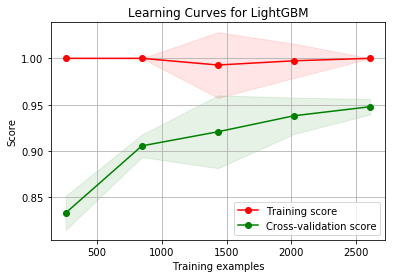

In [57]:
learning_curve(best_buffed, X_train, y_train, cv=5, random_state=1337)

title = "Learning Curves for LightGBM"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = best_buffed
plot_learning_curve(estimator, title, X_scaled, y, cv=cv, n_jobs=3)

In [85]:
from sklearn.utils.estimator_checks import check_estimator
from skbayes.rvm_ard_models import ClassificationARD, RVC
from sklearn.svm import SVC
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
import time
%matplotlib inline

In [81]:
# train rvm 
rvm = RVC(kernel = 'poly', degree=3, gamma = 1, n_iter=300)
t1 = time.time()
rvm.fit(X_scaled, y)
t2 = time.time()
rvm_time = t2 - t1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:362: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\skbayes\rvm_ard_models\fast_rvm.py:47: RuntimeWarning: invalid value encountered in log
  deltaL[add]       = ( Qadd**2 - Sadd ) / Sadd + np.log(Sadd/Qadd**2 )
C:\ProgramData\Anaconda3\lib\site-packages\skbayes\rvm_ard_models\fast_rvm.py:48: RuntimeWarning: invalid value encountered in log
  deltaL[recompute] = Qrec**2 / (Srec + 1. / delta_alpha) - np.log(1 + Srec*delta_alpha)


In [89]:
from skrvm import RVC as skRVC

test = skRVC()
test.fit(X_scaled,y)

NameError: free variable 'gfk' referenced before assignment in enclosing scope

In [70]:
# train svm (and find best parameters through cross-validation)
svc = GridSearchCV(SVC(probability = True), param_grid = {"C":np.logspace(-3,3,9)}, cv = 10)
t1 = time.time()
svc.fit(X_scaled,y)
t2 = time.time()
svm_time = t2 - t1

In [82]:
# report on performance
svecs = svc.best_estimator_.support_vectors_.shape[0]
rvecs = np.sum(rvm.active_[0]==True)
rvm_message = " ====  RVC: time {0}, relevant vectors = {1} \n".format(rvm_time,rvecs)
print(rvm_message)
print(classification_report(y,rvm.predict(X_scaled)))
svm_message = " ====  SVC: time {0}, support vectors  = {1} \n".format(svm_time,svecs)
print(svm_message)
print(classification_report(y,svc.predict(X_scaled)))
print("==============================================")
print(classification_report(y, test.predict(X_scaled)))

 ====  RVC: time 69.14730143547058, relevant vectors = 1 

             precision    recall  f1-score   support

          0       0.49      0.81      0.61      1113
          1       0.78      0.51      0.62      1073
          2       0.53      0.36      0.43      1074

avg / total       0.60      0.56      0.55      3260

 ====  SVC: time 308.56863498687744, support vectors  = 1324 



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:362: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1113
          1       1.00      1.00      1.00      1073
          2       1.00      1.00      1.00      1074

avg / total       1.00      1.00      1.00      3260



<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

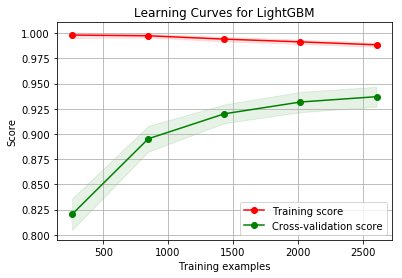

In [33]:
learning_curve(opt.best_estimator_, X_train, y_train, cv=5)

title = "Learning Curves for LightGBM"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = opt.best_estimator_
plot_learning_curve(estimator, title, X_scaled, y, cv=cv, n_jobs=3)

In [33]:
##Sklearn and LightGBM - Round 2 of Random search, n_estimators=200

##Setting up the classifier
gbm_R2 = lgb.LGBMClassifier(n_estimators=300, n_jobs=3,  tree_learner='feature_parallel',
                            save_binary=True, num_class=3)

##Setting up parameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['multiclass'],
    'metric': ['multi_error', 'multi_logloss'],
    'max_depth': [3, 6, 10],
    'num_leaves': [10, 30, 60],
    'min_data_in_leaf': [10, 20, 40],
    'learning_rate': [0.001, 0.05, 0.1, 0.25],
    'colsample_bytree': [0.25, 0.5, 0.75, 0.9],
    'subsample': [0.25, 0.5, 0.75, 0.9],
    'subsample_freq': [1, 5, 10],
    'drop_rate': [0.2, 0.5, 0.9],
    'max_bin': [150, 255, 500],
    'verbose': [1]
}

gbmRnd_R2 = RandomizedSearchCV(estimator=gbm_R2, param_distributions=param_grid, 
                                cv=3, verbose=2, n_iter=300, random_state=2337)
gbmRnd_R2.fit(X_train, y_train)

#Print best model and scores on training data set
print("Best model configuration: " , gbmRnd_R2.best_estimator_)
print("Training set accuracy = " , gbmRnd_R2.best_score_)

##Check validation set accuracy
gbmVal_R2 = gbmRnd_R2.best_estimator_.fit(X_train, y_train)
print("Validation classification accuracy = ", gbmVal_R2.score(X_test, y_test))

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_f

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.0s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_fr

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, 

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   1.3s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   1.3s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5,

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_fr

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   2.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   2.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10,

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.0s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.0s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, 

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.7s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.7s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   2.0s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9,

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, 

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, 

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, 

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   1.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   1.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, 

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsa

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, 

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, 

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   2.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   2.4s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, su

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsampl

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsam

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsampl

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, s

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   2.9s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   2.9s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, 

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, 

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5,

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   1.9s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   1.9s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.0s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.0s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsam

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.3s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsampl

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsa

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsampl

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5,

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10,

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   1.2s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, 

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsampl

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   2.5s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_fr

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsam

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, 

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10,

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subs

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, 

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, 

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5,

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5,

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, su

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsa

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.7s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, obj

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, 

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, 

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.9s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsam

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subs

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.7

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   0.8s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subs

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsampl

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsam

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.1s


[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 38.1min finished


Best model configuration:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
        drop_rate=0.5, learning_rate=0.1, max_bin=500, max_depth=3,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
        n_estimators=200, n_jobs=3, num_class=3, num_leaves=30,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, save_binary=True, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=5,
        tree_learner='feature_parallel', verbose=1)
Training set accuracy =  0.945552147239
Validation classification accuracy =  0.946319018405


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

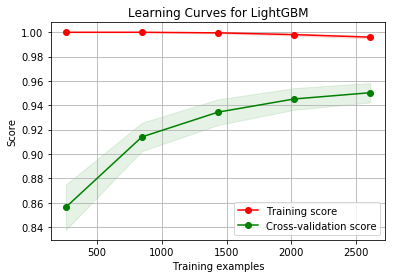

In [34]:
learning_curve(gbmRnd_R2.best_estimator_, X_train, y_train, cv=5)

title = "Learning Curves for LightGBM"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = gbmRnd_R2.best_estimator_
plot_learning_curve(estimator, title, X_scaled, y_binary, cv=cv, n_jobs=2)

In [35]:
##Sklearn and LightGBM - Round 3 of Random search, n_estimators=300

##Setting up the classifier
gbm_R3 = lgb.LGBMClassifier(n_estimators=300, n_jobs=3,  tree_learner='feature_parallel',
                            save_binary=True, num_class=3)

##Setting up parameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['multiclass'],
    'metric': ['multi_error', 'multi_logloss'],
    'max_depth': [3, 6, 10],
    'num_leaves': [10, 30, 60],
    'min_data_in_leaf': [10, 20, 40],
    'learning_rate': [0.001, 0.05, 0.1, 0.25],
    'colsample_bytree': [0.25, 0.5, 0.75, 0.9],
    'subsample': [0.25, 0.5, 0.75, 0.9],
    'subsample_freq': [1, 5, 10],
    'drop_rate': [0.2, 0.5, 0.9],
    'max_bin': [150, 255, 500],
    'verbose': [1]
}

gbmRnd_R3 = RandomizedSearchCV(estimator=gbm_R3, param_distributions=param_grid, 
                                cv=3, verbose=2, n_iter=300, random_state=2337)
gbmRnd_R3.fit(X_train, y_train)

#Print best model and scores on training data set
print("Best model configuration: " , gbmRnd_R3.best_estimator_)
print("Training set accuracy = " , gbmRnd_R3.best_score_)

##Check validation set accuracy
gbmVal_R3 = gbmRnd_R3.best_estimator_.fit(X_train, y_train)
print("Validation classification accuracy = ", gbmVal_R3.score(X_test, y_test))

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   2.6s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   2.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_f

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsa

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_fr

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, 

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   1.0s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   1.0s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   2.8s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   2.9s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   1.7s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.9s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   2.0s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   1.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   1.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5,

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   1.4s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   4.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   4.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5,

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, su

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   3.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   3.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1

[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, 

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   2.7s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   2.6s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   3.1s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   3.6s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5,

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.6s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, 

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5,

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   2.6s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   2.3s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5,

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   1.0s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   2.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   2.2s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   1.1s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   1.4s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.1s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_f

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   1.7s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, su

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   2.8s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   2.7s
[CV] verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   1.2s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsam

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 20.2min finished


Best model configuration:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
        drop_rate=0.5, learning_rate=0.1, max_bin=500, max_depth=3,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
        n_estimators=300, n_jobs=3, num_class=3, num_leaves=30,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, save_binary=True, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=5,
        tree_learner='feature_parallel', verbose=1)
Training set accuracy =  0.945935582822
Validation classification accuracy =  0.95245398773


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

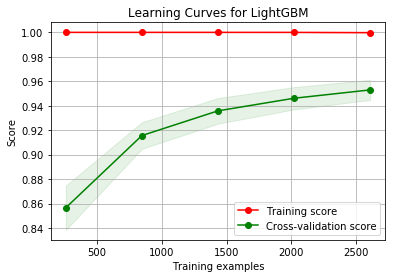

In [36]:
learning_curve(gbmRnd_R3.best_estimator_, X_train, y_train, cv=5)

title = "Learning Curves for LightGBM"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = gbmRnd_R3.best_estimator_
plot_learning_curve(estimator, title, X_scaled, y_binary, cv=cv, n_jobs=2)

In [38]:
from sklearn.externals import joblib
joblib.dump(gbmRnd_R1.best_estimator_, 
            'C:\\Users\\Athena\\Desktop\\Projects\\Research\\SolarStudy\\Models\\gbmRnd_R1.pkl', 
            compress = 1)

joblib.dump(gbmRnd_R2.best_estimator_, 
            'C:\\Users\\Athena\\Desktop\\Projects\\Research\\SolarStudy\\Models\\gbmRnd_R2.pkl', 
            compress = 1)

joblib.dump(gbmRnd_R3.best_estimator_, 
            'C:\\Users\\Athena\\Desktop\\Projects\\Research\\SolarStudy\\Models\\gbmRnd_R3.pkl', 
            compress = 1)

['C:\\Users\\Athena\\Desktop\\Projects\\Research\\SolarStudy\\Models\\gbmRnd_R3.pkl']

In [39]:
##Sklearn and LightGBM - Round 3 of Random search, n_estimators=500

##Setting up the classifier
gbm_R4 = lgb.LGBMClassifier(n_estimators=500, n_jobs=3,  tree_learner='feature_parallel',
                            save_binary=True, num_class=3)

##Setting up parameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'objective': ['multiclass'],
    'metric': ['multi_error', 'multi_logloss'],
    'max_depth': [3, 6, 10],
    'num_leaves': [10, 30, 60],
    'min_data_in_leaf': [10, 20, 40],
    'learning_rate': [0.001, 0.05, 0.1, 0.25],
    'colsample_bytree': [0.25, 0.5, 0.75, 0.9],
    'subsample': [0.25, 0.5, 0.75, 0.9],
    'subsample_freq': [1, 5, 10],
    'drop_rate': [0.2, 0.5, 0.9],
    'max_bin': [150, 255, 500],
    'verbose': [1]
}

gbmRnd_R4 = RandomizedSearchCV(estimator=gbm_R4, param_distributions=param_grid, 
                                cv=5, verbose=2, n_iter=100, random_state=2337)
gbmRnd_R4.fit(X_train, y_train)

#Print best model and scores on training data set
print("Best model configuration: " , gbmRnd_R4.best_estimator_)
print("Training set accuracy = " , gbmRnd_R4.best_score_)

##Check validation set accuracy
gbmVal_R4 = gbmRnd_R4.best_estimator_.fit(X_train, y_train)
print("Validation classification accuracy = ", gbmVal_R4.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=10, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart, total=   1.8s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1,

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   3.2s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=  11.1s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   7.3s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   5.0s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   4.2s
[CV] verbose=1, subsample_freq=1, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   3.9s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   4.0s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   8.9s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart, total=   8.6s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=255, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.9, boosting_type=dart 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=150, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_fr

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   9.0s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   9.9s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=500, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_fre

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.05, drop_rate=0.9, colsample_bytree=0.5, boosting_type=dart, total=   8.3s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   3.6s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.3s
[CV] verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.05, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=10, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=10, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   4.3s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subs

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.5, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, subsam

[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=150, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=  17.2s
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total= 1.4min
[CV] verbose=1, subsample_freq=10, subsample=0.75, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_f

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   5.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   6.0s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=500, learning_rate=0.001, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   2.2s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=10, metric=multi_logloss, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq

[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   3.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart, total=   3.2s
[CV] verbose=1, subsample_freq=5, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=40, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=10, max_bin=255, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.9, boosting_type=gbdt, total=   0.9s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart, total=   6.4s
[CV] verbose=1, subsample_freq=1, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsampl

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt, total=   0.7s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt, total=   0.4s
[CV] verbose=1, subsample_freq=5, subsample=0.9, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.9, colsample_bytree=0.25, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, sub

[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=30, min_data_in_leaf=40, metric=multi_error, max_depth=3, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsamp

[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   5.2s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   5.1s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=10, max_bin=150, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   6.4s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_logloss, max_depth=6, max_bin=150, learning_rate=0.001, drop_rate=0.5, colsample_bytree=0.5, boosting_type=dart, total=   6.6s
[CV] verbose=1, subsample_freq=10, subsample=0.9, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=500, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=10, su

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   3.2s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart, total=   3.1s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.2, colsample_bytree=0.25, boosting_type=dart 
[CV]  verbose=1, subsample_freq=5, subsample=0

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=500, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=gbdt, total=   1.0s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt, total=   0.8s
[CV] verbose=1, subsample_freq=5, subsample=0.75, objective=multiclass, num_leaves=60, min_data_in_leaf=40, metric=multi_logloss, max_depth=6, max_bin=255, learning_rate=0.25, drop_rate=0.5, colsample_bytree=0.75, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, su

[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.5s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt, total=   0.6s
[CV] verbose=1, subsample_freq=5, subsample=0.5, objective=multiclass, num_leaves=30, min_data_in_leaf=20, metric=multi_error, max_depth=3, max_bin=500, learning_rate=0.1, drop_rate=0.5, colsample_bytree=0.9, boosting_type=gbdt 
[CV]  verbose=1, subsample_freq=5, subsample=0.5, obje

[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   3.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart, total=   3.3s
[CV] verbose=1, subsample_freq=10, subsample=0.5, objective=multiclass, num_leaves=60, min_data_in_leaf=20, metric=multi_error, max_depth=6, max_bin=150, learning_rate=0.1, drop_rate=0.2, colsample_bytree=0.5, boosting_type=dart 
[CV]  verbose=1, subsample_freq=10, subsample=0.5,

[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   3.7s
[CV] verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart 
[CV]  verbose=1, subsample_freq=1, subsample=0.25, objective=multiclass, num_leaves=10, min_data_in_leaf=20, metric=multi_logloss, max_depth=3, max_bin=255, learning_rate=0.1, drop_rate=0.9, colsample_bytree=0.75, boosting_type=dart, total=   3.8s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 40.2min finished


Best model configuration:  LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
        drop_rate=0.5, learning_rate=0.25, max_bin=500, max_depth=3,
        metric='multi_logloss', min_child_samples=20,
        min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
        n_estimators=500, n_jobs=3, num_class=3, num_leaves=60,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, save_binary=True, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=10,
        tree_learner='feature_parallel', verbose=1)
Training set accuracy =  0.947085889571
Validation classification accuracy =  0.955521472393


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

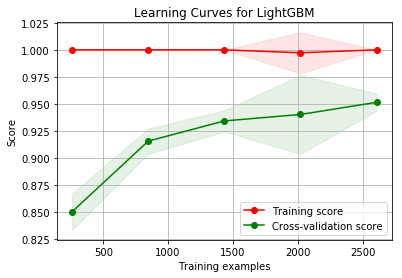

In [40]:
learning_curve(gbmRnd_R4.best_estimator_, X_train, y_train, cv=5)

title = "Learning Curves for LightGBM"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = gbmRnd_R4.best_estimator_
plot_learning_curve(estimator, title, X_scaled, y_binary, cv=cv, n_jobs=2)